<h1 align="center">Теоретические вопросы (2 балла) </h1> 

** Задача 1**
Покажите, что ROC-AUC  в случае, когда классификатор даёт случайные ответы $a(x) = 1$ с вероятностью $p$ и $a(x) = 0$ с вероятностью $1 − p$, будет в среднем равен 0.5 независимо от p и доли класса 1 в обучающей выборке.

***Решение***:

ROC-AUC -- площадь под ROC-curve, где ROC-curve -- кривая отношения True Positive Rate к False Positive Rate.

$$TPR = \cfrac{\sum{I\{\bar{y} = 1; y=1\}}}{\#\{y=1\}}$$
$$FPR = \cfrac{\sum{I\{\bar{y} = 1; y=0\}}}{\#\{y=0\}}$$

Посчитаем матожидание TPR и FPR.
$$E[TPR] = \cfrac{p\cdot\#\{y=1\}}{\#\{y=1\}} = p$$
$$E[TPR] = \cfrac{p\cdot\#\{y=0\}}{\#\{y=0\}} = p$$

Таким образом, в среднем $\cfrac{TPR}{FPR} = 1$. Это значит, что ROC-curve -- прямая под углом 45. Тогда AUC-ROC = 0.5.

** Задача 2**
Покажите, что с ростом размерности пространства признаков при равномерном распределении точек в кубе $[0; 1]^d$ вероятность попасть в куб $[0; 0, 99]^d$ стремится к нулю. Это одна из иллюстраций проклятия размерностей (dimension curse). Попробуйте придумать или найти еще какую-нибудь иллюстрацию к этому явлению и кратко изложить.

***Решение:***

Для того чтобы попасть в куб $[0; 0, 99]^d$, нужно попасть в отрезок $[0; 0, 99]$ по каждой размерности. Так как по условию точки распределены равномерно в кубе $[0; 1]^d$, то они распределены равномерно по каждой размерности. Тогда

$$P(x \in [0; 0, 99]^d) = \prod_{i=1}^{d}{P(x_{i} \in [0; 0, 99])} = (0, 99)^{d} \rightarrow_{d \rightarrow \infty} 0$$

<h1 align="center">Исследуйте зависимость Bias-Variance для kNN (3 балла) </h1> 

Используя данные из задачи классификации доходов индивидуума http://archive.ics.uci.edu/ml/machine-learning-databases/adult, постройте зависимость величин bias, variance и noise для следующих пар "модель|параметр".
Предобработка данных (преобразование признаков, разметка классов) определяется вами. 

* kNN, $n\_neigbours$ - число соседей при классификации;
* $p$ - степень метрики Минковского;
* $\ell\_train$ - длина обучающий выборки;


По каждому построенному графику (для каждого параметра должен быть отдельный график) объясните полученную картину. Совпадает ли она с теоретическими ожиданиями (см. семинар 2)?

In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import euclidean_distances, accuracy_score
from sklearn.datasets import load_digits
from copy import deepcopy, copy

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
warnings.simplefilter("ignore")

In [3]:
names = ['Age', 'Workclass', 'Fnlwgt', 'Education',
         'Education-num', 'Marital-status', 'Occupation',
         'Relationship', 'Race', 'Sex', 'Capital-gain',
         'Capital-loss', 'Hours-per-week', 'Native-country',
         'Class']

races = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
         'Other', 'Black']

workclasses = ['Private', 'Self-emp-not-inc', 'Self-emp-inc',
               'Federal-gov', 'Local-gov', 'State-gov',
               'Without-pay', 'Never-worked']

educations = ['Bachelors', 'Some-college', '11th', 'HS-grad',
              'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th',
              '7th-8th', '12th', 'Masters', '1st-4th', '10th',
              'Doctorate', '5th-6th', 'Preschool']

drop_columns = ['Race', 'Workclass', 'Education', 'Marital-status',
                'Occupation', 'Relationship', 'Native-country']

In [33]:
data = pd.read_csv('adult.data', names=names, skipinitialspace=True, na_values=['?'])

Многие `features` описаны как какие-то слова. Избавлюсь от этого с помощью `one hot encoding`. Если в колонке много различных значений, то выкину эту колонку. Так же поступлю с колонками, которые, как мне кажется, не влияют на `target`.

In [34]:
# Change features types

# Male - 1, Female - 0
data['Sex'] = data.apply(lambda row: int(row['Sex'] == 'Male'), axis=1)

# >50K - 1, <=50K - 0
data['Class'] = data.apply(lambda row: int(row['Class'] == '>50K'), axis=1)

for race in races:
    data[race] = data.apply(lambda row: int(row['Race'] == race), axis=1)
    
for workclass in workclasses:
    data[workclass] = data.apply(lambda row: int(row['Workclass'] == workclass), axis=1)

for education in educations:
    data[education] = data.apply(lambda row: int(row['Education'] == education), axis=1)
    
data.drop(axis=1, columns=drop_columns, inplace=True)

In [35]:
# Move target column (Class) to the end of the table
columns = data.columns.tolist()
columns = columns[:7] + columns[8:] + columns[7:8]
data = data[columns]

In [36]:
data.head()

,Age,Fnlwgt,Education-num,Sex,Capital-gain,Capital-loss,Hours-per-week,White,Asian-Pac-Islander,Amer-Indian-Eskimo,...,9th,7th-8th,12th,Masters,1st-4th,10th,Doctorate,5th-6th,Preschool,Class
0,39,77516,13,1,2174,0,40,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311,13,1,0,0,13,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646,9,1,0,0,40,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721,7,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409,13,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Settings
n_repeat = 100       # Number of iterations for computing expectations
test_size = 0.5       # (Relative) Size of the test set

# Research parameters 
parameters = {"k": range(1, 20), "p":  np.arange(1, 10, 0.5), "l_train": np.arange(0.5, 2, 0.1)}

In [9]:
# Get Data
train , test = train_test_split(data, test_size=test_size)

In [10]:
X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1:].values
n_test = len(test)

In [11]:
X_train = []
y_train = []

In [12]:
# Bootstrapping
for i in range(n_repeat):
    sample_train = train.sample(len(train), replace=True) 
    X, y = sample_train.iloc[:, :-1], sample_train.iloc[:, -1:]
    X_train.append(X)
    y_train.append(y)

### Полезные иллюстрации

![error](img/error.png)

![bias_variance](img/bias_variance.png)

### Исследование зависимости от p

In [13]:
p_name ='p'
bias_variance_df = pd.DataFrame.from_dict({p_name: parameters[p_name],
                                           'bias': list([np.NaN]*len(parameters[p_name])),
                                           'variance':list([np.NaN]*len(parameters[p_name])),
                                           'error':list([np.NaN]*len(parameters[p_name]))})
for parameter in parameters[p_name]:
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator = KNeighborsClassifier(p=parameter,
                                         n_neighbors=10,
                                         n_jobs=-1).fit(X_train[i].values,
                                                        y_train[i].values.ravel())
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)
    y_error = np.sum((y_test.repeat(n_repeat, axis=1) - y_predict)**2, axis=1)
    y_error /= n_repeat

    y_bias = (y_test.ravel() - np.mean(y_predict, axis=1).ravel()) ** 2
    
    y_var = np.var(y_predict, axis=1)
    
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'bias'] = y_bias.mean()
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'variance'] = y_var.mean()
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'error'] = y_error.mean()

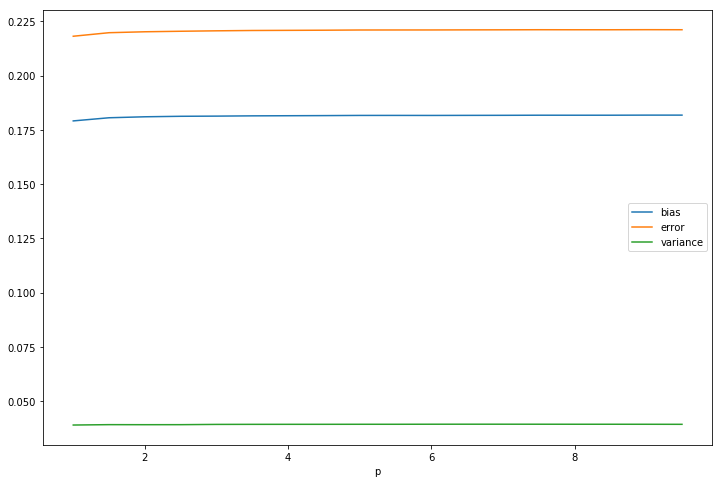

In [14]:
bias_variance_df.plot.line('p', ['bias', 'error', 'variance'], figsize=(12,8))
plt.show()

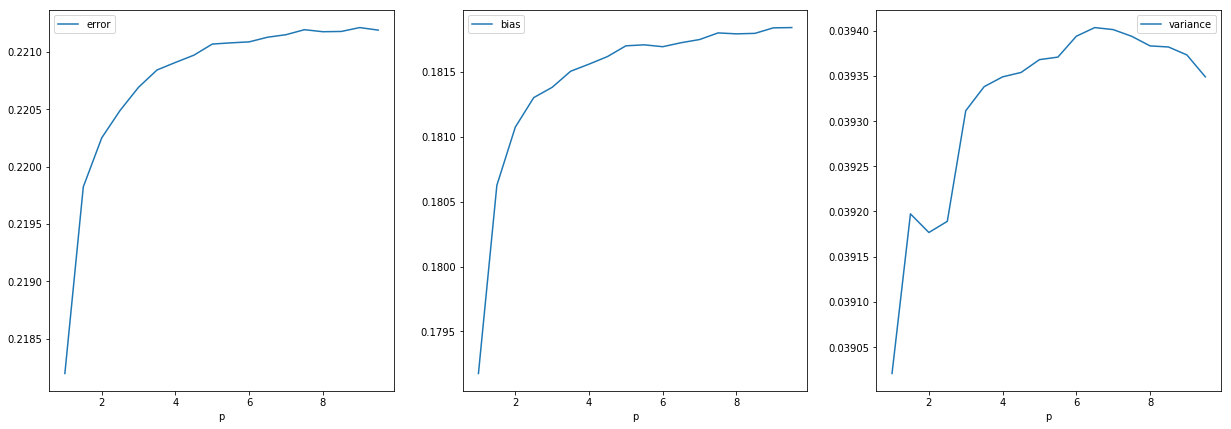

In [15]:
fig = plt.figure(figsize=(21,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
bias_variance_df.plot.line('p', 'error', ax=ax1)
bias_variance_df.plot.line('p', 'bias', ax=ax2)
bias_variance_df.plot.line('p', 'variance', ax=ax3)
plt.show()

***Вывод:*** Параметр `p` отвечает за размерность метрики Минковского. Графики соответствуют ожиданиям: получили три прямые, что подтверждает ожидание того, что ошибка зависит от размерности метрики не сильно. Обычно используют `p = 1` или `p = 2`. На графиках видно, что при таких `p` получаются наименьшие значения `bias` и `variance`.

### Исследование зависимости от k

In [16]:
p_name ='k'
bias_variance_df = pd.DataFrame.from_dict({p_name: parameters[p_name],
                                           'bias': list([np.NaN]*len(parameters[p_name])),
                                           'variance':list([np.NaN]*len(parameters[p_name])),
                                           'error':list([np.NaN]*len(parameters[p_name]))})
for parameter in parameters[p_name]:
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator = KNeighborsClassifier(p=5,
                                         n_neighbors=parameter,
                                         n_jobs=-1).fit(X_train[i].values,
                                                        y_train[i].values.ravel())
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)
    y_error = np.sum((y_test.repeat(n_repeat, axis=1) - y_predict)**2, axis=1)
    y_error /= n_repeat

    y_bias = (y_test.ravel() - np.mean(y_predict, axis=1).ravel()) ** 2
    
    y_var = np.var(y_predict, axis=1)
    
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'bias'] = y_bias.mean()
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'variance'] = y_var.mean()
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'error'] = y_error.mean()

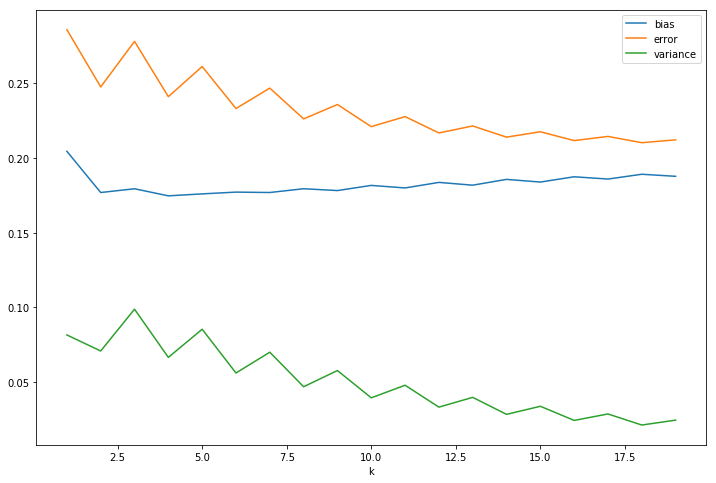

In [17]:
bias_variance_df.plot.line('k', ['bias', 'error', 'variance'], figsize=(12,8))
plt.show()

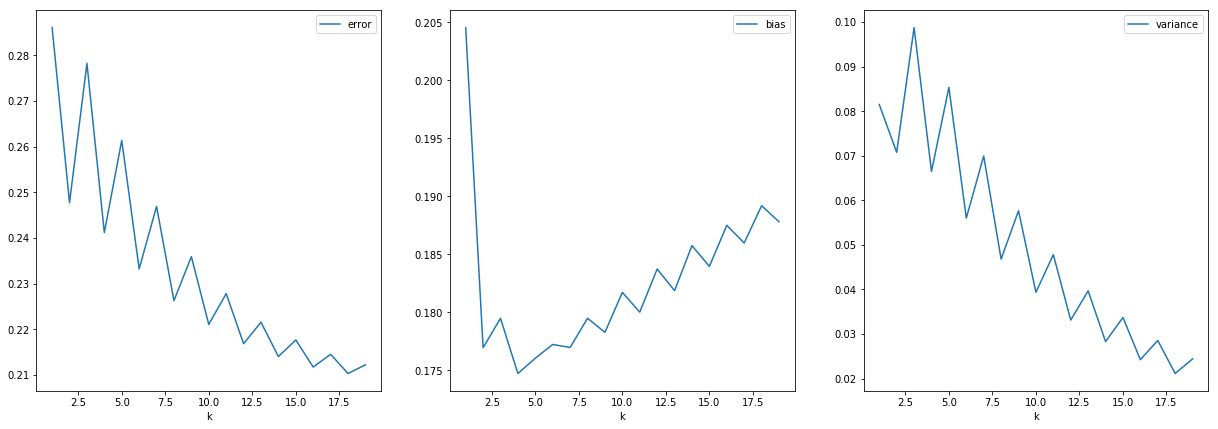

In [18]:
fig = plt.figure(figsize=(21,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
bias_variance_df.plot.line('k', 'error', ax=ax1)
bias_variance_df.plot.line('k', 'bias', ax=ax2)
bias_variance_df.plot.line('k', 'variance', ax=ax3)
plt.show()

***Вывод:***  Параметр `k` отвечает за количество соседей, которые учитываются в `KNeighbourClassifier` (количество соседей). Самый интересный параметр. В данном случае графики совпадают с теорией (см. картинки в начале раздела). При увеличении `k` происходит увеличение `bias` и уменьшение `variance`. Это означает следующее: при больших `k` модель становится простой - начиная с некоторого `k` мы будем давать тот класс, элементов которого было больше в тестовой выборке. Получаем недообученную модель. При маленьких `k` получаем переобученную модель - будем оценивать по ближайшему соседу, результат будет очень чувствителен к шуму и выборосам.
* Большой `bias`, малый `variance` - недообучение;
* Малый `bias`, большой `variance` - переобучение.

### Исследолвание зависимости от l_train

Так как `l_train` отвечает за размер обучающей выборке относительно тестовой, то пересчитаем его как параметр `test_size` в `train_test_split`.

Обозначив `x -- test_size`, получим:
$$ l\_train \cdot x + x = 1 \implies x = \cfrac{1}{1 + l\_train}$$ 

In [19]:
p_name ='l_train'
bias_variance_df = pd.DataFrame.from_dict({p_name: parameters[p_name],
                                           'bias': list([np.NaN]*len(parameters[p_name])),
                                           'variance':list([np.NaN]*len(parameters[p_name])),
                                           'error':list([np.NaN]*len(parameters[p_name]))})
for parameter in parameters[p_name]:
    test_size = 1 / (1 + parameter)
    train , test = train_test_split(data, test_size=test_size)
    
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1:].values
    n_test = len(test)
    
    X_train = []
    y_train = []
    
    for i in range(n_repeat):
        sample_train = train.sample(len(train), replace=True) 
        X, y = sample_train.iloc[:, :-1], sample_train.iloc[:, -1:]
        X_train.append(X)
        y_train.append(y)
    
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator = KNeighborsClassifier(p=5,
                                         n_neighbors=10,
                                         n_jobs=-1).fit(X_train[i].values,
                                                        y_train[i].values.ravel())
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)
    y_error = np.sum((y_test.repeat(n_repeat, axis=1) - y_predict)**2, axis=1)
    y_error /= n_repeat

    y_bias = (y_test.ravel() - np.mean(y_predict, axis=1).ravel()) ** 2
    
    y_var = np.var(y_predict, axis=1)
    
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'bias'] = y_bias.mean()
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'variance'] = y_var.mean()
    bias_variance_df.loc[bias_variance_df[p_name]==parameter, 'error'] = y_error.mean()

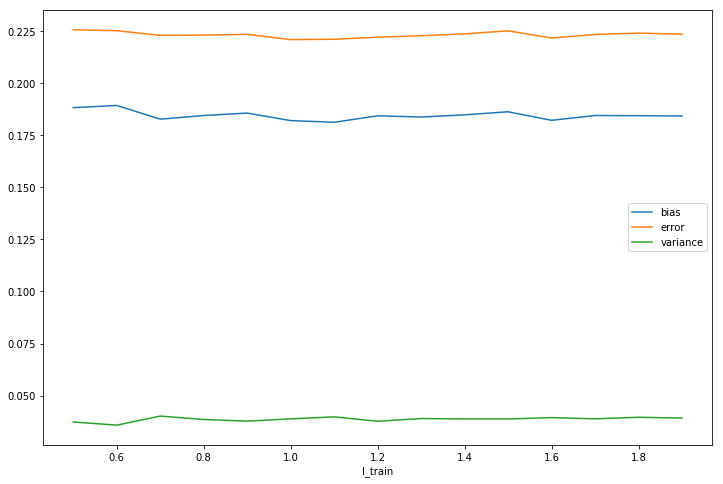

In [20]:
bias_variance_df.plot.line('l_train', ['bias', 'error', 'variance'], figsize=(12,8))
plt.show()

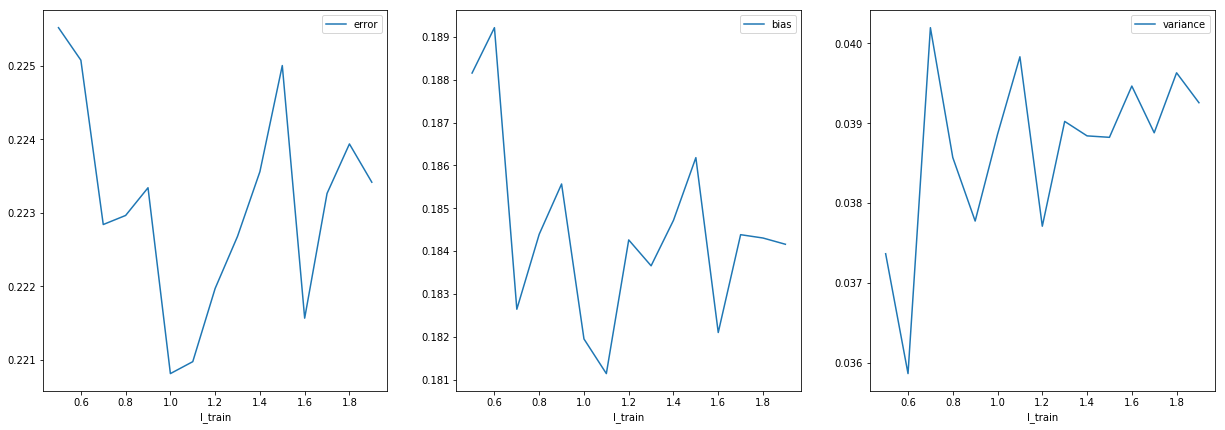

In [21]:
fig = plt.figure(figsize=(21,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
bias_variance_df.plot.line('l_train', 'error', ax=ax1)
bias_variance_df.plot.line('l_train', 'bias', ax=ax2)
bias_variance_df.plot.line('l_train', 'variance', ax=ax3)
plt.show()

***Вывод:*** Параметр `l_train` отвечает за "размер" обучающей выборки. Графики совпадают с теорией: от длины выборки (т.е. просто от выборки) результат конечно зависит, но так как с данными все в порядке, то разница получается не сильной - графики похожи на прямые, а значения `bias` и `variance` меняются быстро (пики чередуются).

<h2 align="center">Реализуйте kNN (2 балла)</h2>

In [22]:
def euclidean(x, Y):
    return np.sum((x - Y) ** 2, axis=-1)

In [23]:
class kNNClassifier():
    def __init__(self, n_neighbours, metric):
        """
        Parameters
        ----------
        n_neighbours: int
            Число соседей
        metric: *alias
            метрика измерения расстояний
        """
        self.n_neighbours = n_neighbours
        self.metric = metric
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X: 2d np.array
        y: 1d np.array
        """
        self.X_learn = X
        self.y_learn = y
        
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X: 2d np.array матрица объекты признаки на которых нужно сказать ответ
        
        Returns
        -------
        y_pred: 1d np.array, вектор классов для каждого объекта
        """
        y_pred = []
        for x in X:
            dist = self.metric(x, self.X_learn)
            args = np.argsort(dist)[:self.n_neighbours]
            target = sum(self.y_learn[args])
            if 2 * target > self.n_neighbours:
                y_pred += [1]
            elif 2 * target < self.n_neighbours:
                y_pred += [0]
            else:
                y_pred += [self.y_learn[args[0]]]
        
        return np.array(y_pred)

Запустим алгоритм на данных http://archive.ics.uci.edu/ml/machine-learning-databases/adult

Обучим классификатор при k = 3, 5 и 10.

In [38]:
train , test = train_test_split(data, test_size=test_size)

X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1:].values.ravel()

X_train = []
y_train = []

for i in range(n_repeat):
    sample_train = train.sample(len(train), replace=True) 
    X, y = sample_train.iloc[:, :-1], sample_train.iloc[:, -1:]
    X_train.append(X)
    y_train.append(y)

In [39]:
X = X_train[0].values
y = y_train[0].values.ravel()

In [40]:
for k in [3, 5, 10]:
    clf = kNNClassifier(k, euclidean)
    clf.fit(X, y)
    print('***** k = {} *****'.format(k))
    print('{:.4f}'.format(accuracy_score(clf.predict(X), y)))
    print('{:.4f}'.format(accuracy_score(clf.predict(X_test), y_test)))

***** k = 3 *****
0.9241
0.7196
***** k = 5 *****
0.8674
0.7387
***** k = 10 *****
0.8461
0.7641


<h1 align="center">Отбор признаков (3 балла) </h1>

Реализуйте алгоритм отбора признаков ADD_DELL и примените его для kNN на данных sklearn.datasets.digits().

Псевдкод каждого из алгоритмов ниже.

![add](img/add.png)

![add_del](img/add_del.png)

In [27]:
def update_Q_min_index(estimator, Q_min, Q_min_set, Q_min_index, feature_set, X_train, Y_train, X_test, Y_test, update_equal=False):
    feature_set_size = len(feature_set)
    estimator.fit(X_train[:, feature_set], Y_train)
    error = 1 - accuracy_score(Y_test, estimator.predict(X_test[:, feature_set]))
    if error < Q_min[feature_set_size]:
        Q_min_set[feature_set_size] = feature_set
        Q_min[feature_set_size] = error
        if ((Q_min[feature_set_size] < Q_min[Q_min_index])
                or (update_equal and Q_min[feature_set_size] == Q_min[Q_min_index])):
            Q_min_index = feature_set_size
    return Q_min_index

def add_one(estimator, feature_set, X_train, Y_train, X_test, Y_test, look_forward=10, start_feature_set=[]):
    Q_min = {0: float('+inf')}
    Q_min_set = {0: []}
    Q_min_index = 0
    
    # Initialization
    if start_feature_set:
        estimator.fit(X_train[:, feature_set], Y_train)
        error = 1 - accuracy_score(Y_test, estimator.predict(X_test[:, feature_set]))
        Q_min = {len(start_feature_set) : error}
        Q_min_set = {len(start_feature_set) : start_feature_set}
        Q_min_index = len(start_feature_set)
    
    # Add
    for feature_set_size in range(len(start_feature_set) + 1, len(feature_set) + 1):
        Q_min[feature_set_size] = float('+inf')
        unused_features = set(feature_set).difference(set(Q_min_set[feature_set_size - 1]))
        unused_features = list(unused_features)
        #shuffle(unused_features)
        for feature in unused_features:
            new_feature_set = Q_min_set[feature_set_size - 1] + [feature]
            Q_min_index = update_Q_min_index(estimator, Q_min, Q_min_set, Q_min_index, new_feature_set, X_train, Y_train, X_test, Y_test, update_equal=False)
        
        print ('Q_min: %.4lf, set_size: %d, added: %s' % (Q_min[feature_set_size], feature_set_size, Q_min_set[feature_set_size][-1]))        
    
    # Stopping Criteria
        if Q_min_index + look_forward <= feature_set_size:
            break
    return Q_min_set[Q_min_index]

def del_one(estimator, feature_set, X_train, Y_train, X_test, Y_test, look_forward=10):
    # Initialization
    estimator.fit(X_train[:, feature_set], Y_train)
    error = 1 - accuracy_score(Y_test, estimator.predict(X_test[:, feature_set]))
    Q_min = {len(feature_set): error}
    Q_min_set = {len(feature_set): deepcopy(feature_set)}
    Q_min_index = len(feature_set)
    
    # Del
    for feature_set_size in list(range(len(feature_set) - 1, 0, -1)):
        Q_min[feature_set_size] = float('+inf')
        features = copy(Q_min_set[feature_set_size + 1])
        # shuffle(features)
        for feature in features:
            new_feature_set = list(set(features).difference([feature]))
            Q_min_index = update_Q_min_index(estimator, Q_min, Q_min_set, Q_min_index, new_feature_set, X_train, Y_train, X_test, Y_test, update_equal=False)
            
        print ('Q_min: %.4lf, set_size: %d, deleted: %s' % (Q_min[feature_set_size], feature_set_size,
            set(Q_min_set[feature_set_size + 1]).difference(set(Q_min_set[feature_set_size])),
        ))
        
    # Stopping Criteria
        if feature_set_size + look_forward <= Q_min_index:
            break
    return Q_min_set[Q_min_index]

def add_del(estimator, feature_set, X_train, Y_train, X_test, Y_test, look_forward=10):
    Q_min = None
    Q_min_current = float('+inf')
    start_feature_set = []
    
    bad_iteration_count = 2
    
    while (Q_min is None) or (Q_min_current < Q_min or bad_iteration_count):
        Q_min = Q_min_current
        start_feature_set = add_one(estimator, feature_set, X_train, Y_train, X_test, Y_test, look_forward, start_feature_set=start_feature_set)
        start_feature_set = del_one(estimator, start_feature_set, X_train, Y_train, X_test, Y_test, look_forward)
        estimator.fit(X_train[:, start_feature_set], Y_train)
        Q_min_current = 1 - accuracy_score(Y_test, estimator.predict(X_test[:, start_feature_set]))
        
        if Q_min_current >= Q_min:
            bad_iteration_count -= 1
        print ('Q_min: %.4lf, set_size: %d' % (Q_min_current, len(start_feature_set)))
    return start_feature_set

In [28]:
data = load_digits()

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(data.data, data.target, test_size=0.33)
estimator = KNeighborsClassifier()
%time feature_set = add_del(estimator, list(range(X_train.shape[1])), X_train, Y_train, X_test, Y_test, look_forward=4)
%time accuracy_score(Y_test, estimator.fit(X_train[:, feature_set], Y_train).predict(X_test[:, feature_set]))

Q_min: 0.7458, set_size: 1, added: 34
Q_min: 0.6111, set_size: 2, added: 30
Q_min: 0.4882, set_size: 3, added: 43
Q_min: 0.3502, set_size: 4, added: 26
Q_min: 0.2761, set_size: 5, added: 50
Q_min: 0.2121, set_size: 6, added: 21
Q_min: 0.1566, set_size: 7, added: 27
Q_min: 0.1111, set_size: 8, added: 10
Q_min: 0.0875, set_size: 9, added: 61
Q_min: 0.0572, set_size: 10, added: 28
Q_min: 0.0522, set_size: 11, added: 4
Q_min: 0.0455, set_size: 12, added: 11
Q_min: 0.0421, set_size: 13, added: 6
Q_min: 0.0354, set_size: 14, added: 42
Q_min: 0.0286, set_size: 15, added: 52
Q_min: 0.0236, set_size: 16, added: 19
Q_min: 0.0152, set_size: 17, added: 54
Q_min: 0.0135, set_size: 18, added: 38
Q_min: 0.0135, set_size: 19, added: 0
Q_min: 0.0135, set_size: 20, added: 1
Q_min: 0.0135, set_size: 21, added: 7
Q_min: 0.0135, set_size: 22, added: 8
Q_min: 0.0168, set_size: 17, deleted: {11}
Q_min: 0.0236, set_size: 16, deleted: {6}
Q_min: 0.0286, set_size: 15, deleted: {38}
Q_min: 0.0303, set_size: 14, 

0.9865319865319865